In [1]:
import math
import torch
import gpytorch
import pandas as pd
import numpy as np
from matplotlib import pyplot as plts
import os
import GPE_ensemble as GPE

from GPErks.gp.experiment import GPExperiment
from GPErks.train.emulator import GPEmulator
from GPErks.perks.inference import Inference
from GPErks.train.early_stop import NoEarlyStoppingCriterion
from GPErks.train.early_stop import (
    GLEarlyStoppingCriterion,
    PQEarlyStoppingCriterion,
    UPEarlyStoppingCriterion, 
)
from GPErks.train.early_stop import PkEarlyStoppingCriterion

%matplotlib inline
%load_ext autoreload
%autoreload 2

from sklearn.model_selection import train_test_split

# set logger and enforce reproducibility
from GPErks.log.logger import get_logger
from GPErks.utils.random import set_seed
log = get_logger()
seed = 8
set_seed(seed)

In [2]:
for i in range(17):
    print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16


In [3]:
allSimulationsOutput_ventricles = pd.read_csv(r'C:\Users\pmzcwl\Documents\GitHub\Calibration\shared_simulations\EP_healthy\output\YV.txt',index_col=None,delim_whitespace=True,header=None)
allSimulationsOutput_atria = pd.read_csv(r'C:\Users\pmzcwl\Documents\GitHub\Calibration\shared_simulations\EP_healthy\output\YA.txt',index_col=None,delim_whitespace=True,header=None)
allSimulationsOutput = pd.read_csv(r'C:\Users\pmzcwl\Documents\GitHub\Calibration\shared_simulations\EP_healthy\output\simulations\all_simulations.csv',index_col=None,delim_whitespace=False,header=None)

In [4]:
#allSimulationsOutput_ventricles = pd.read_csv(r'C:\Users\pmzcwl\Documents\GitHub\Calibration\shared_simulations\EP_healthy\01\YV.txt',index_col=None,delim_whitespace=True,header=None)
#allSimulationsOutput_atria = pd.read_csv(r'C:\Users\pmzcwl\Documents\GitHub\Calibration\shared_simulations\EP_healthy\01\YA.txt',index_col=None,delim_whitespace=True,header=None)
#allSimulationsOutput = pd.read_csv(r'C:\Users\pmzcwl\Documents\GitHub\Calibration\shared_simulations\EP_healthy\01\simulations\all_simulations.csv',index_col=None,delim_whitespace=False,header=None)

In [5]:
np.max(allSimulationsOutput.iloc[:,25])

209.087061

In [6]:
allSimulationsOutput_combined = pd.concat([allSimulationsOutput_atria,allSimulationsOutput_ventricles],axis=0)

In [7]:
allSimulationsOutput_combined.shape

(434591, 180)

In [8]:
x_labels=pd.read_csv(r'C:\Users\pmzcwl\Documents\GitHub\Calibration\shared_simulations\EP_healthy\input\xlabels_EP.txt',delim_whitespace=True,header=None)
inputOrig = pd.read_csv(r'C:\Users\pmzcwl\Documents\GitHub\Calibration\shared_simulations\EP_healthy\input\X_EP.txt',index_col=None,delim_whitespace=True,header=None)
inputOrig.columns=x_labels


In [9]:


# split original dataset in training, validation and testing sets
X=inputOrig
y=allSimulationsOutput_ventricles.T

X_train, X_test, PCA_train_ventricles, PCA_test_ventricles = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=seed
)


In [10]:
X=inputOrig
y=allSimulationsOutput_atria.T

X_train2, X_test2, PCA_train_atria, PCA_test_atria = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=seed
)

In [11]:
X=inputOrig
y=allSimulationsOutput.T

X_train2, X_test2, PCA_train_all, PCA_test_all = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=seed
)

In [12]:
X=inputOrig
y=allSimulationsOutput_combined.T

X_train2, X_test2, PCA_train_c, PCA_test_c = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=seed
)

In [13]:
from sklearn.decomposition import PCA
pca_EP_V = PCA()
principalComponents_EP_V = pca_EP_V.fit_transform(PCA_train_ventricles)

pca_EP_A = PCA()
principalComponents_EP_A = pca_EP_A.fit_transform(PCA_train_atria)

pca_EP_All = PCA()
principalComponents_EP_All = pca_EP_All.fit_transform(PCA_train_all)

pca_EP_c = PCA()
principalComponents_EP_c = pca_EP_c.fit_transform(PCA_train_c)

In [17]:
pca_EP_All.explained_variance_ratio_

array([5.57050736e-01, 3.97066781e-01, 2.50137391e-02, 1.56935684e-02,
       3.23108995e-03, 1.32624440e-03, 1.88458875e-04, 1.30128200e-04,
       9.14888435e-05, 5.15017984e-05, 2.93727713e-05, 2.44839291e-05,
       2.26820943e-05, 1.40547430e-05, 9.64929481e-06, 7.75915658e-06,
       6.93801561e-06, 4.30370819e-06, 4.19322491e-06, 3.43642464e-06,
       2.78293221e-06, 2.52005963e-06, 2.33116734e-06, 1.83354011e-06,
       1.36611993e-06, 1.28843554e-06, 1.14826028e-06, 1.10745666e-06,
       9.63330714e-07, 8.90097386e-07, 8.09011788e-07, 7.27316269e-07,
       6.36632894e-07, 5.74697593e-07, 4.95286857e-07, 4.84230148e-07,
       4.35505666e-07, 4.15064354e-07, 3.79240344e-07, 3.33160598e-07,
       3.14509937e-07, 2.94703401e-07, 2.75973759e-07, 2.58902300e-07,
       2.48282302e-07, 2.30922905e-07, 2.21931030e-07, 1.97989418e-07,
       1.95791701e-07, 1.88483530e-07, 1.81466371e-07, 1.70944583e-07,
       1.52903791e-07, 1.49421430e-07, 1.45425094e-07, 1.37418036e-07,
      

In [18]:
principalComponents_EP_c.shape

(144, 144)

In [19]:
from matplotlib import pyplot as plt

(array([21., 38., 29., 22., 10.,  8.,  3.,  8.,  4.,  1.]),
 array([-19176.63188088, -12700.35143827,  -6224.07099565,    252.20944696,
          6728.48988957,  13204.77033218,  19681.05077479,  26157.3312174 ,
         32633.61166001,  39109.89210262,  45586.17254523]),
 <BarContainer object of 10 artists>)

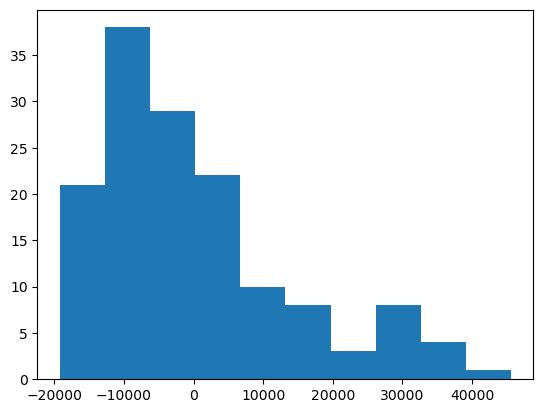

In [20]:
plt.hist(principalComponents_EP_V[:,0])

In [21]:
print('Explained variation per principal component (All): {}'.format(pca_EP_All.explained_variance_ratio_))

Explained variation per principal component (All): [5.57050736e-01 3.97066781e-01 2.50137391e-02 1.56935684e-02
 3.23108995e-03 1.32624440e-03 1.88458875e-04 1.30128200e-04
 9.14888435e-05 5.15017984e-05 2.93727713e-05 2.44839291e-05
 2.26820943e-05 1.40547430e-05 9.64929481e-06 7.75915658e-06
 6.93801561e-06 4.30370819e-06 4.19322491e-06 3.43642464e-06
 2.78293221e-06 2.52005963e-06 2.33116734e-06 1.83354011e-06
 1.36611993e-06 1.28843554e-06 1.14826028e-06 1.10745666e-06
 9.63330714e-07 8.90097386e-07 8.09011788e-07 7.27316269e-07
 6.36632894e-07 5.74697593e-07 4.95286857e-07 4.84230148e-07
 4.35505666e-07 4.15064354e-07 3.79240344e-07 3.33160598e-07
 3.14509937e-07 2.94703401e-07 2.75973759e-07 2.58902300e-07
 2.48282302e-07 2.30922905e-07 2.21931030e-07 1.97989418e-07
 1.95791701e-07 1.88483530e-07 1.81466371e-07 1.70944583e-07
 1.52903791e-07 1.49421430e-07 1.45425094e-07 1.37418036e-07
 1.33886545e-07 1.27939081e-07 1.27069649e-07 1.21479723e-07
 1.15716178e-07 1.13096986e-07 1.0

In [22]:
print('Explained variation per principal component (Atria): {}'.format(pca_EP_A.explained_variance_ratio_))

Explained variation per principal component (Atria): [9.60782861e-01 3.60826564e-02 2.42775475e-03 4.14716589e-04
 9.04511791e-05 6.66609496e-05 5.18302047e-05 1.77656981e-05
 1.47239490e-05 9.65536600e-06 5.97501269e-06 5.40388155e-06
 4.33657117e-06 2.70530446e-06 2.48453084e-06 1.96427514e-06
 1.80805991e-06 1.42592954e-06 1.16115462e-06 1.01145467e-06
 9.27565928e-07 7.43671512e-07 7.18731035e-07 5.93431298e-07
 5.20460442e-07 4.81018868e-07 4.22920938e-07 3.99614571e-07
 3.65629029e-07 3.23976052e-07 3.22565909e-07 2.86581689e-07
 2.63963735e-07 2.56185373e-07 2.40738491e-07 2.36149763e-07
 2.14982321e-07 1.94904258e-07 1.85891174e-07 1.76917103e-07
 1.70284295e-07 1.61523552e-07 1.55988318e-07 1.38588832e-07
 1.32695812e-07 1.29317651e-07 1.27227999e-07 1.16809881e-07
 1.12475375e-07 1.10540395e-07 1.08350985e-07 1.04515888e-07
 1.01968910e-07 9.37638087e-08 9.20739118e-08 8.89818564e-08
 8.67794093e-08 8.61957138e-08 8.25231559e-08 7.86723672e-08
 7.74758176e-08 7.35216257e-08 7

In [23]:
print('Explained variation per principal component (Ventricles): {}'.format(pca_EP_V.explained_variance_ratio_))

Explained variation per principal component (Ventricles): [9.56961670e-01 3.76737338e-02 4.95795092e-03 1.98476898e-04
 1.07767048e-04 3.52588343e-05 2.38226237e-05 1.10271445e-05
 5.90453242e-06 4.93795154e-06 3.74969897e-06 2.30657945e-06
 1.71080301e-06 1.60845014e-06 1.11949208e-06 7.65076042e-07
 6.82723430e-07 6.17078341e-07 5.09674119e-07 3.56771116e-07
 3.23010497e-07 2.82123430e-07 2.34914401e-07 2.03375273e-07
 1.93783613e-07 1.86026103e-07 1.61991984e-07 1.57392240e-07
 1.49331245e-07 1.36124593e-07 1.33775461e-07 1.23467224e-07
 1.18837704e-07 1.09682897e-07 1.06269580e-07 1.02865340e-07
 9.79779527e-08 9.63531096e-08 9.13943897e-08 8.58354785e-08
 7.90565594e-08 7.77278209e-08 7.52696150e-08 7.28180422e-08
 7.02522535e-08 6.60441411e-08 6.52432398e-08 6.38244016e-08
 5.95773090e-08 5.85370347e-08 5.71574834e-08 5.61348110e-08
 5.47172243e-08 5.36174424e-08 5.14083107e-08 4.96756405e-08
 4.76642267e-08 4.67101685e-08 4.56520835e-08 4.50652534e-08
 4.30696703e-08 4.20421814e

In [24]:
print('Explained variation per principal component (combined): {}'.format(pca_EP_c.explained_variance_ratio_))

Explained variation per principal component (combined): [5.66075683e-01 3.92873281e-01 2.19851320e-02 1.48491270e-02
 2.76673334e-03 9.33245085e-04 1.71157409e-04 1.08316087e-04
 6.39135588e-05 3.55241311e-05 2.79928135e-05 2.04994837e-05
 1.97813133e-05 1.36765948e-05 7.16771160e-06 6.50233830e-06
 6.14843564e-06 4.11529157e-06 3.31608112e-06 2.76537617e-06
 2.41467205e-06 2.17465329e-06 2.08703197e-06 1.60524492e-06
 1.29212634e-06 1.18276969e-06 1.07430434e-06 8.96546693e-07
 8.27368791e-07 7.59112012e-07 6.54830515e-07 6.02676402e-07
 5.73212519e-07 4.75529661e-07 4.32455909e-07 4.22447707e-07
 3.58551646e-07 3.41977993e-07 3.22867503e-07 3.11047862e-07
 3.02886187e-07 2.82088602e-07 2.37109841e-07 2.25733178e-07
 2.11606858e-07 1.96045366e-07 1.88275165e-07 1.77033596e-07
 1.74567676e-07 1.70142010e-07 1.60777610e-07 1.46512344e-07
 1.45493531e-07 1.35737056e-07 1.30981989e-07 1.25904160e-07
 1.16632856e-07 1.12767121e-07 1.10290553e-07 1.08800973e-07
 1.05968396e-07 1.00932684e-0

In [25]:
np.matmul(principalComponents_EP_A,pca_EP_A.components_)+pca_EP_A.mean_

array([[ 49.3671,  45.8879,  48.4414, ..., 113.747 , 221.139 ,  91.5276],
       [ 21.1713,  19.7853,  21.0176, ...,  42.3486,  75.4846,  42.8967],
       [ 31.6   ,  29.3683,  31.0048, ...,  85.8132, 167.358 ,  58.2388],
       ...,
       [ 40.1352,  37.5985,  39.8369, ...,  85.4165, 153.086 ,  78.4516],
       [ 33.9072,  32.1175,  33.6374, ...,  72.7998, 125.928 ,  59.1373],
       [ 60.6745,  56.6062,  60.2707, ..., 134.786 , 258.444 , 125.33  ]])

In [26]:
PCA_train_atria

,0,1,2,3,4,5,6,7,8,9,...,97975,97976,97977,97978,97979,97980,97981,97982,97983,97984
67,49.3671,45.8879,48.4414,48.3523,171.3610,172.8810,170.3960,170.8880,197.9260,198.0460,...,78.9507,193.3260,238.3320,97.8385,208.9960,165.1300,99.4013,113.7470,221.1390,91.5276
141,21.1713,19.7853,21.0176,20.7047,63.2437,63.9691,62.7852,63.0014,94.9813,95.0346,...,25.4017,69.2927,84.0495,34.1315,69.4425,50.2801,45.8746,42.3486,75.4846,42.8967
88,31.6000,29.3683,31.0048,30.9396,134.0960,134.7480,133.4920,133.6370,125.5600,125.6180,...,66.8803,154.0180,182.4130,78.8293,175.3800,147.4420,63.2386,85.8132,167.3580,58.2388
30,61.0945,56.8715,60.1547,59.5473,176.1190,178.3260,175.1700,175.8780,238.5820,238.7530,...,75.9980,187.5140,230.5820,95.7249,195.1300,143.2800,122.3980,124.2440,209.0880,111.9460
57,34.5462,32.1278,34.1178,33.9520,124.5430,125.6940,123.8090,124.1790,150.9700,151.0640,...,56.0025,141.8790,173.7540,70.7405,150.6400,117.8280,74.0423,81.4512,160.2360,68.7602
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83,28.2901,26.4755,28.0795,27.6775,86.3512,87.2897,85.7549,86.0333,125.0140,125.0740,...,35.4409,95.2542,115.2750,46.9026,96.2961,69.8867,60.7221,57.8468,104.1450,56.5849
136,41.5858,38.9214,41.2680,40.6924,130.9670,132.3970,130.0540,130.5350,182.7630,182.8590,...,54.7921,146.2410,176.6680,71.8011,148.6650,109.7470,88.8918,87.2602,160.1870,82.9604
133,40.1352,37.5985,39.8369,39.6990,126.0110,127.4390,125.2630,125.7160,171.2610,171.3780,...,53.6398,139.1510,167.9300,69.0357,142.6190,105.9960,85.1483,85.4165,153.0860,78.4516
105,33.9072,32.1175,33.6374,33.2803,102.3320,103.4930,102.1110,102.1340,123.5850,123.8100,...,47.3340,110.3550,136.8820,57.3952,118.9390,91.9076,65.3763,72.7998,125.9280,59.1373


In [27]:
testOutPCA_A = pca_EP_A.transform(PCA_test_atria)
testOutPCA_V = pca_EP_V.transform(PCA_test_ventricles)
testOutPCA_All = pca_EP_All.transform(PCA_test_all)
testOutPCA_c = pca_EP_c.transform(PCA_test_c)

TestExperiment dataset loaded.
Notes from the author:
"An example dataset to test GPErks' power!"
Dataset properties:
-Input size: 6
-Input parameters: ['CV_ventricles', 'k_ventricles', 'k_FEC', 'CV_atria', 'k_atria', 'k_BB']
-Output size: 1
-Output feature: ['y']
-Sample size: 144
-Discrepancy: 0.0081
-Validation data available: No
-Testing data available: Yes (size = 36)


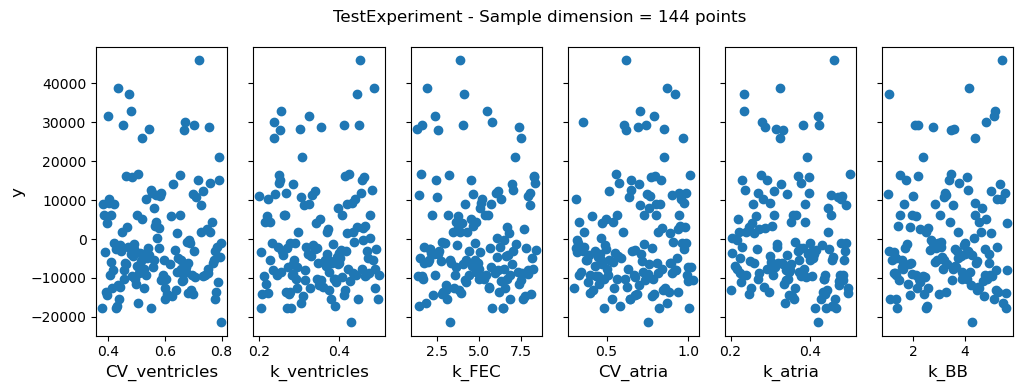

In [28]:
from GPErks.gp.data.dataset import Dataset
dataset = Dataset(
        X_train.values,
        principalComponents_EP_All[:,0],
        X_test=X_test.values,
        y_test=testOutPCA_All,
        x_labels=x_labels.values.squeeze().tolist(),
    
        )
dataset.plot()
#dataset.plot_pairwise()

TestExperiment dataset loaded.
Notes from the author:
"An example dataset to test GPErks' power!"
Dataset properties:
-Input size: 6
-Input parameters: ['CV_ventricles', 'k_ventricles', 'k_FEC', 'CV_atria', 'k_atria', 'k_BB']
-Output size: 1
-Output feature: ['y']
-Sample size: 144
-Discrepancy: 0.0081
-Validation data available: No
-Testing data available: Yes (size = 36)


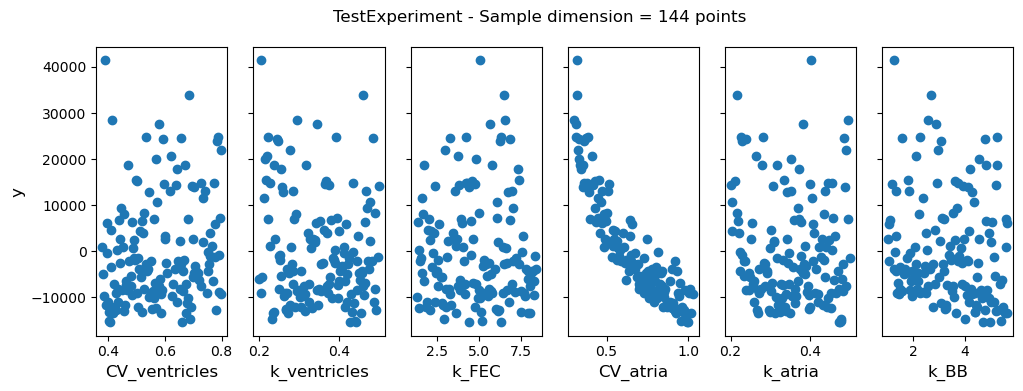

In [29]:
from GPErks.gp.data.dataset import Dataset
dataset = Dataset(
        X_train.values,
        principalComponents_EP_A[:,0],
        X_test=X_test.values,
        y_test=testOutPCA_A,
        x_labels=x_labels.values.squeeze().tolist(),
    
        )
dataset.plot()
#dataset.plot_pairwise()

TestExperiment dataset loaded.
Notes from the author:
"An example dataset to test GPErks' power!"
Dataset properties:
-Input size: 6
-Input parameters: ['CV_ventricles', 'k_ventricles', 'k_FEC', 'CV_atria', 'k_atria', 'k_BB']
-Output size: 1
-Output feature: ['y']
-Sample size: 144
-Discrepancy: 0.0081
-Validation data available: No
-Testing data available: Yes (size = 36)


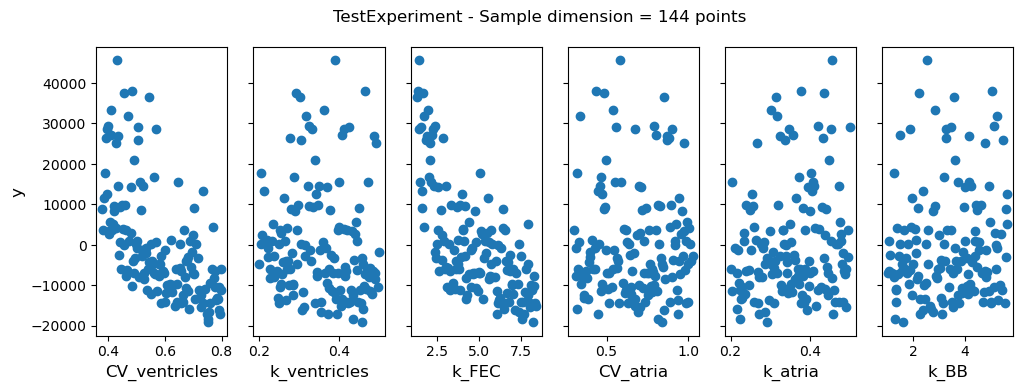

In [30]:
from GPErks.gp.data.dataset import Dataset
dataset = Dataset(
        X_train.values,
        principalComponents_EP_V[:,0],
        X_test=X_test.values,
        y_test=testOutPCA_V,
        x_labels=x_labels.values.squeeze().tolist(),
    
        )
dataset.plot()

TestExperiment dataset loaded.
Notes from the author:
"An example dataset to test GPErks' power!"
Dataset properties:
-Input size: 6
-Input parameters: ['CV_ventricles', 'k_ventricles', 'k_FEC', 'CV_atria', 'k_atria', 'k_BB']
-Output size: 1
-Output feature: ['y']
-Sample size: 144
-Discrepancy: 0.0081
-Validation data available: No
-Testing data available: Yes (size = 36)


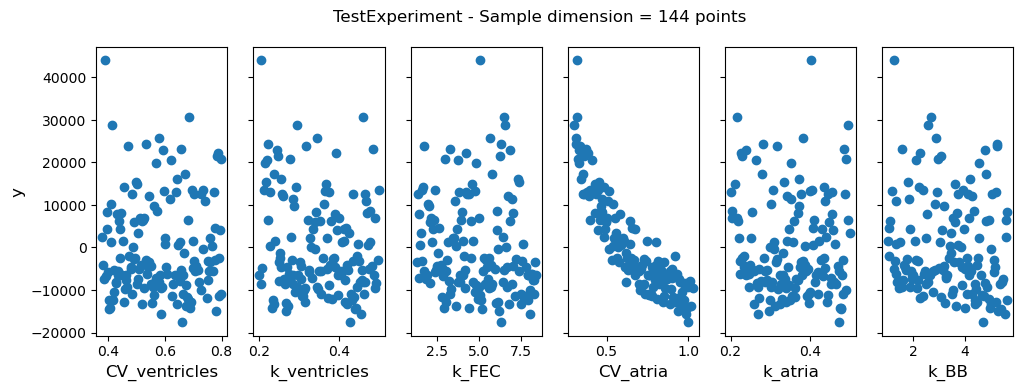

In [31]:
from GPErks.gp.data.dataset import Dataset
dataset = Dataset(
        X_train.values,
        principalComponents_EP_c[:,1],
        X_test=X_test.values,
        y_test=testOutPCA_c,
        x_labels=x_labels.values.squeeze().tolist(),
    
        )
dataset.plot()

In [64]:
end=50

In [65]:
GPE_output_A = pd.DataFrame(principalComponents_EP_A[:,0:end])
GPE_output_V = pd.DataFrame(principalComponents_EP_V[:,0:end])
GPE_output_All = pd.DataFrame(principalComponents_EP_All[:,0:end])
GPE_output_c = pd.DataFrame(principalComponents_EP_c[:,0:end])

In [66]:
GPE_All = GPE.ensemble(X_train,GPE_output_All,mean_func='linear')

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


In [67]:
GPE_A = GPE.ensemble(X_train,GPE_output_A,mean_func='linear')

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


In [68]:
GPE_V = GPE.ensemble(X_train,GPE_output_V,mean_func='linear')

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


In [69]:
GPE_C = GPE.ensemble(X_train,GPE_output_c,mean_func='linear')

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


In [70]:
GPE_All.MSE(X_test,pd.DataFrame(testOutPCA_All[:,0:end]))

tensor([2.3757e+08, 1.6162e+08, 8.2852e+06, 6.3659e+06, 1.0180e+06, 2.6485e+05,
        7.0275e+04, 3.2161e+04, 1.8793e+04, 6.8291e+03, 9.8051e+03, 7.4537e+03,
        7.8368e+03, 7.2259e+03, 2.6468e+03, 4.7331e+03, 2.1807e+03, 1.3532e+03,
        1.3502e+03, 1.2437e+03, 8.5328e+02, 1.2640e+03, 1.0233e+03, 6.1515e+02,
        5.1159e+02, 4.1460e+02, 3.4379e+02, 5.3467e+02, 5.4184e+02, 3.7229e+02,
        2.4388e+02, 3.3577e+02, 2.9646e+02, 3.2226e+02, 2.7929e+02, 1.0390e+02,
        1.3584e+02, 7.0270e+01, 1.3315e+02, 1.0921e+02, 5.7126e+01, 1.6833e+02,
        1.3289e+02, 8.7006e+01, 7.7809e+01, 4.8537e+01, 1.2359e+02, 4.7882e+01,
        4.1163e+01, 9.6880e+01], dtype=torch.float64, grad_fn=<MeanBackward1>)

Text(0.5, 0, 'component')

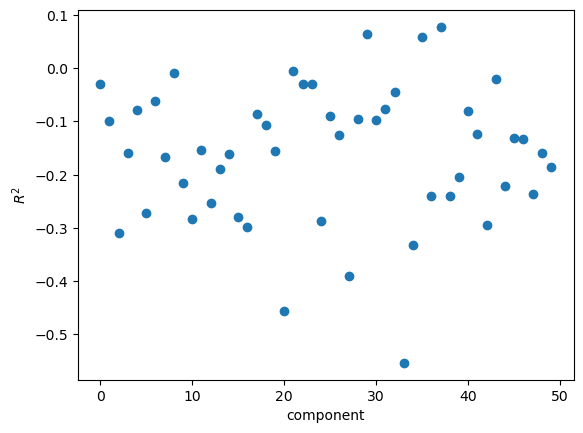

In [81]:
plt.plot(GPE_All.R2(X_test,pd.DataFrame(testOutPCA_All[:,0:end])).detach().numpy(),'o')
plt.ylabel('$R^2$')
plt.xlabel('component')

Text(0.5, 0, 'component')

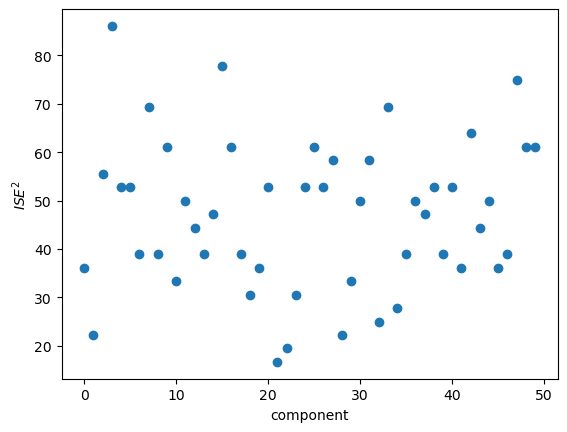

In [82]:
plt.plot(GPE_All.ISE(X_test,pd.DataFrame(testOutPCA_All[:,0:end])).detach().numpy(),'o')
plt.ylabel('$ISE^2$')
plt.xlabel('component')

Text(0.5, 0, 'component')

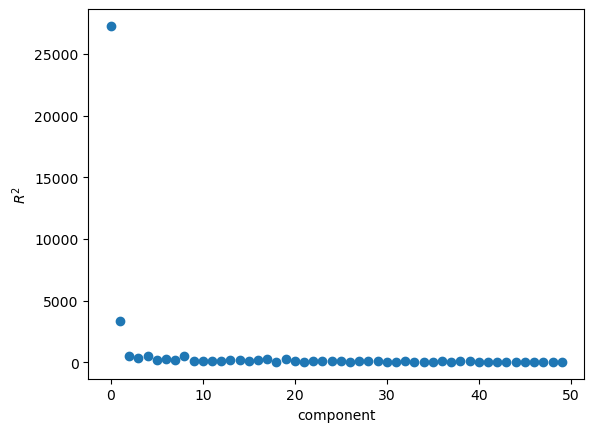

In [83]:
plt.plot(GPE_A.MSE(X_test,pd.DataFrame(testOutPCA_A[:,0:end])).detach().numpy(),'o')
plt.ylabel('$R^2$')
plt.xlabel('component')

Text(0.5, 0, 'component')

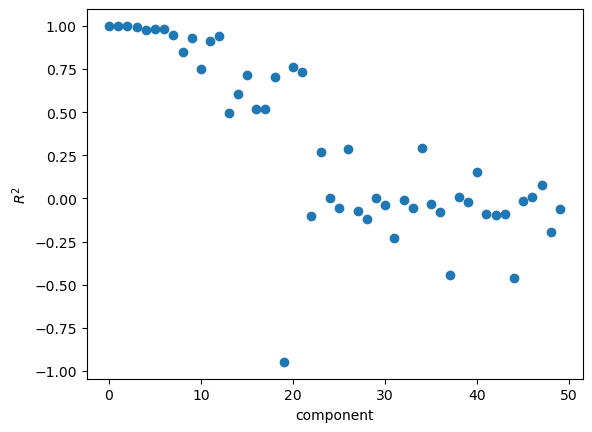

In [84]:
plt.plot(GPE_A.R2(X_test,pd.DataFrame(testOutPCA_A[:,0:end])).detach().numpy(),'o')
plt.ylabel('$R^2$')
plt.xlabel('component')

Text(0.5, 0, 'component')

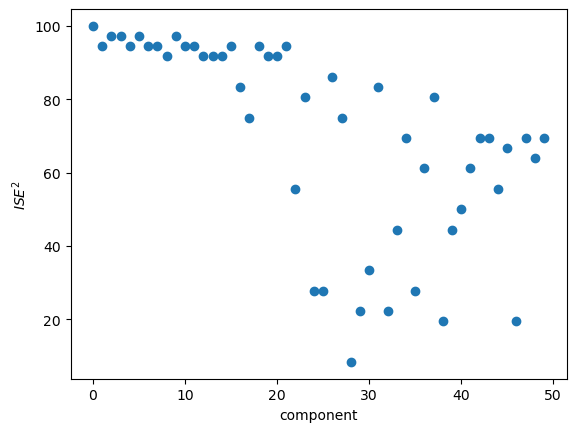

In [85]:
plt.plot(GPE_A.ISE(X_test,pd.DataFrame(testOutPCA_A[:,0:end])).detach().numpy(),'o')
plt.ylabel('$ISE^2$')
plt.xlabel('component')

In [86]:
np.var(testOutPCA_V[:,0:end],axis=1).shape

(36,)

In [87]:
GPE_V.MSE(X_test,pd.DataFrame(testOutPCA_V[:,0:end]))

tensor([3.0366e+04, 9.5092e+03, 4.2017e+02, 3.9115e+02, 5.4727e+01, 1.0930e+02,
        7.4961e+01, 7.9458e+01, 1.0108e+02, 7.0216e+01, 8.1760e+01, 4.5351e+01,
        5.3240e+01, 7.5407e+01, 5.5216e+01, 1.7030e+02, 1.9398e+02, 3.2051e+01,
        5.7139e+01, 6.1103e+01, 6.4442e+01, 4.5491e+01, 4.2298e+01, 1.2353e+02,
        4.5603e+01, 3.7710e+01, 3.3439e+01, 3.3256e+01, 2.0771e+01, 2.7871e+01,
        3.5142e+01, 4.2814e+01, 1.4823e+01, 4.9607e+01, 1.0041e+01, 2.1705e+01,
        1.6911e+01, 1.1273e+01, 1.0437e+01, 5.1932e+00, 1.3316e+01, 1.3561e+01,
        1.0708e+01, 1.1211e+01, 7.2497e+00, 9.6598e+00, 5.9302e+00, 6.6089e+00,
        7.4935e+00, 5.0316e+00], dtype=torch.float64, grad_fn=<MeanBackward1>)

Text(0, 0.5, '$R^2$')

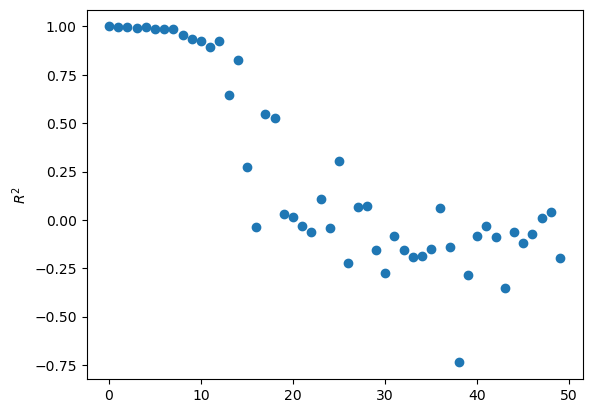

In [88]:
plt.plot(GPE_V.R2(X_test,pd.DataFrame(testOutPCA_V[:,0:end])).detach().numpy(),'o')
plt.ylabel('$R^2$')

Text(0.5, 0, 'component')

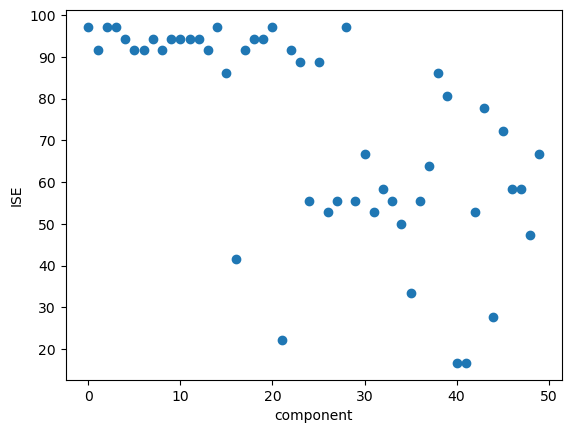

In [89]:
plt.plot(GPE_V.ISE(X_test,pd.DataFrame(testOutPCA_V[:,0:end])).detach().numpy(),'o')
plt.ylabel('ISE')
plt.xlabel('component')

Text(0, 0.5, '$R^2$')

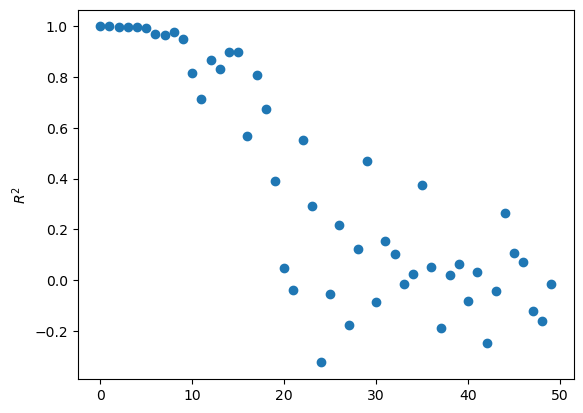

In [90]:
plt.plot(GPE_C.R2(X_test,pd.DataFrame(testOutPCA_c[:,0:end])).detach().numpy(),'o')
plt.ylabel('$R^2$')

Text(0, 0.5, '$R^2$')

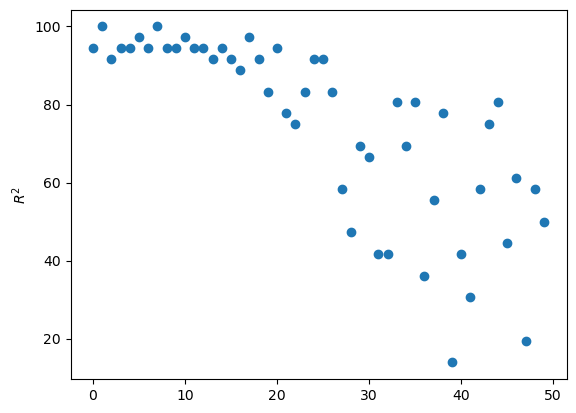

In [92]:
plt.plot(GPE_C.ISE(X_test,pd.DataFrame(testOutPCA_c[:,0:end])).detach().numpy(),'o')
plt.ylabel('$R^2$')

In [91]:
compPred_All = GPE_All.predict(X_test)
compPred_A = GPE_A.predict(X_test)
compPred_V = GPE_V.predict(X_test)
compPred_C = GPE_C.predict(X_test)

In [50]:
compPred_A.detach().numpy().shape

(36, 10)

In [51]:
pca_EP_A.mean_.shape

(97985,)

In [52]:
pca_EP_A.components_.shape

(144, 97985)

In [53]:
np.matmul(compPred_A.detach().numpy(),pca_EP_A.components_[0:end])[0].shape

(97985,)

In [54]:
np.var(PCA_test_atria,axis=1)

26     1796.297472
56      597.860914
50      388.327592
103    1069.781998
25      722.597980
65     2308.750988
1      2155.532325
23     2351.181653
170     597.288938
27     2090.425839
40     1932.826772
122    2376.727401
130     364.592920
126    2132.366691
89     1974.026105
121    2900.562404
52     1336.500558
80     1282.716429
127    3066.051018
4       683.194528
139     655.453169
134     663.287295
131     657.073382
153    1960.985778
156    1122.610161
17     2774.663027
172    1257.392945
135     466.075295
159    2446.200053
3       440.631534
152     482.606355
90     2481.606835
146    2226.468896
132    3774.631446
117    1407.082932
69     1046.370579
dtype: float64

In [56]:
r2_atria = np.zeros(end)
r2_ventricle = np.zeros(end)
r2_all = np.zeros(end)
r2_c = np.zeros(end)
for i in range(end):
    j=i+1
    r2_atria[i] =(1-((np.matmul(compPred_A.detach().numpy()[:,0:j],pca_EP_A.components_[0:j])+pca_EP_A.mean_-PCA_test_atria)**2).mean(axis=1)/np.var(PCA_test_atria,axis=1)).mean()
    r2_ventricle[i]=(1-((np.matmul(compPred_V.detach().numpy()[:,0:j],pca_EP_V.components_[0:j])+pca_EP_V.mean_-PCA_test_ventricles)**2).mean(axis=1)/np.var(PCA_test_ventricles,axis=1)).mean()
    r2_all[i]=(1-((np.matmul(compPred_All.detach().numpy()[:,0:j],pca_EP_All.components_[0:j])+pca_EP_All.mean_-PCA_test_all)**2).mean(axis=1)/np.var(PCA_test_all,axis=1)).mean()
    r2_c[i]=(1-((np.matmul(compPred_C.detach().numpy()[:,0:j],pca_EP_c.components_[0:j])+pca_EP_c.mean_-PCA_test_c)**2).mean(axis=1)/np.var(PCA_test_c,axis=1)).mean()

Text(0.5, 0, 'Number of components')

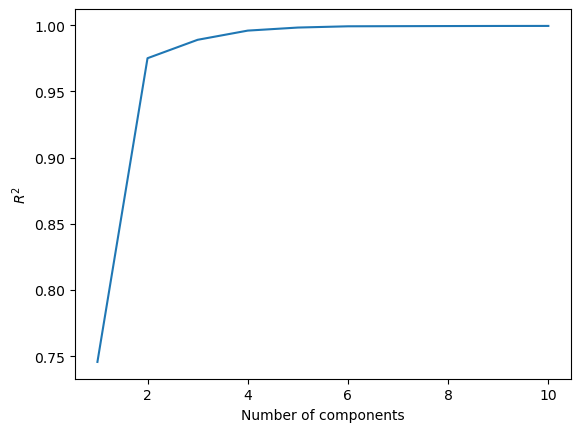

In [63]:
plt.plot(np.linspace(1,end,end),r2_c)
plt.ylabel('$R^2$')
plt.xlabel('Number of components')

In [53]:
nDim = X_train.shape[1]
boundsMaxMin = []
for i in range(nDim):
    boundsMaxMin.append([np.min(X_train.iloc[:,i]),np.max(X_train.iloc[:,i])])
    print(boundsMaxMin[i])

[0.380173, 0.798883]
[0.200114, 0.499215]
[1.2811, 8.39681]
[0.300285, 1.02928]
[0.201206, 0.499887]
[1.02207, 5.67575]


In [130]:
##### from SALib.sample import saltelli
from SALib.sample import saltelli
from SALib.analyze import sobol
from SALib.test_functions import Ishigami
import numpy as np

# Define the model inputs
problem = {
    'num_vars': nDim,
    'names': x_labels,
    'bounds': boundsMaxMin
    #'bounds': [[-1, 1],
     #          [-1, 1],
      #         [-1, 1],
       #        [-1, 1],
        #       [-1, 1],
         #      [-1, 1],
          #     [-1, 1],
           #    [-1, 1],
            #   [-1,1]]
}

# Generate samples
param_values = saltelli.sample(problem, 1024)

data1 = pd.DataFrame(param_values,columns=x_labels)
Ymean_A=GPE_A.predict(data1)
Ymean_V=GPE_V.predict(data1)
Ymean_C = GPE_C.predict(data1)

C:\Users\pmzcwl\AppData\Local\Temp\ipykernel_18564\2691961068.py:24: DeprecationWarning: `salib.sample.saltelli` will be removed in SALib 1.5. Please use `salib.sample.sobol`
  param_values = saltelli.sample(problem, 1024)


In [55]:
nMod = len(GPE_V.models)

In [56]:
Si_A = []
for i in range(nMod):
    Si_A.append(sobol.analyze(problem, Ymean_A[:,i].detach().numpy(), print_to_console=True))

                        ST   ST_conf
(CV_ventricles,)  0.000016  0.000004
(k_ventricles,)   0.000011  0.000003
(k_FEC,)          0.000009  0.000002
(CV_atria,)       0.893112  0.066353
(k_atria,)        0.021808  0.002357
(k_BB,)           0.099770  0.011284
                        S1   S1_conf
(CV_ventricles,)  0.000053  0.000337
(k_ventricles,)  -0.000027  0.000311
(k_FEC,)         -0.000057  0.000234
(CV_atria,)       0.876985  0.093402
(k_atria,)        0.018966  0.013179
(k_BB,)           0.090605  0.032185
Empty DataFrame
Columns: [S2, S2_conf]
Index: []
                        ST   ST_conf
(CV_ventricles,)  0.000086  0.000028
(k_ventricles,)   0.000117  0.000043
(k_FEC,)          0.000121  0.000029
(CV_atria,)       0.121404  0.015184
(k_atria,)        0.006379  0.000784
(k_BB,)           0.978462  0.086557
                        S1   S1_conf
(CV_ventricles,) -0.000295  0.000743
(k_ventricles,)   0.000159  0.000885
(k_FEC,)          0.000105  0.000967
(CV_atria,)       0.012755

In [57]:
Si_V = []
for i in range(nMod):
    Si_V.append(sobol.analyze(problem, Ymean_V[:,i].detach().numpy(), print_to_console=True))

                        ST   ST_conf
(CV_ventricles,)  0.365358  0.043005
(k_ventricles,)   0.050443  0.005555
(k_FEC,)          0.608867  0.054658
(CV_atria,)       0.000016  0.000004
(k_atria,)        0.000025  0.000006
(k_BB,)           0.000021  0.000005
                        S1   S1_conf
(CV_ventricles,)  0.339874  0.040725
(k_ventricles,)   0.047538  0.023302
(k_FEC,)          0.583266  0.073894
(CV_atria,)      -0.000013  0.000301
(k_atria,)        0.000073  0.000375
(k_BB,)           0.000367  0.000381
Empty DataFrame
Columns: [S2, S2_conf]
Index: []
                        ST   ST_conf
(CV_ventricles,)  0.322905  0.031031
(k_ventricles,)   0.508241  0.039198
(k_FEC,)          0.201440  0.026474
(CV_atria,)       0.000048  0.000008
(k_atria,)        0.000122  0.000030
(k_BB,)           0.000076  0.000012
                        S1   S1_conf
(CV_ventricles,)  0.293798  0.043547
(k_ventricles,)   0.486260  0.059991
(k_FEC,)          0.189686  0.044087
(CV_atria,)      -0.000299

In [131]:
Si_C = []
for i in range(nMod):
    Si_C.append(sobol.analyze(problem, Ymean_C[:,i].detach().numpy(), print_to_console=True))

                        ST   ST_conf
(CV_ventricles,)  0.356286  0.038308
(k_ventricles,)   0.047680  0.005751
(k_FEC,)          0.596813  0.056211
(CV_atria,)       0.021531  0.002426
(k_atria,)        0.000527  0.000074
(k_BB,)           0.002185  0.000287
                        S1   S1_conf
(CV_ventricles,)  0.332629  0.045714
(k_ventricles,)   0.044134  0.022295
(k_FEC,)          0.571321  0.078914
(CV_atria,)       0.020453  0.012950
(k_atria,)        0.000582  0.002027
(k_BB,)           0.002514  0.003849
Empty DataFrame
Columns: [S2, S2_conf]
Index: []
                        ST   ST_conf
(CV_ventricles,)  0.012332  0.001262
(k_ventricles,)   0.001568  0.000164
(k_FEC,)          0.018228  0.002277
(CV_atria,)       0.865716  0.062102
(k_atria,)        0.021184  0.002288
(k_BB,)           0.096146  0.011723
                        S1   S1_conf
(CV_ventricles,)  0.011737  0.008461
(k_ventricles,)   0.001181  0.003440
(k_FEC,)          0.016159  0.010738
(CV_atria,)       0.848040

In [132]:
SiA_first=np.zeros((nDim,nMod))
SiA_total=np.zeros((nDim,nMod))
SiV_first=np.zeros((nDim,nMod))
SiV_total=np.zeros((nDim,nMod))
SiC_first=np.zeros((nDim,nMod))
SiC_total=np.zeros((nDim,nMod))
for i in range(nMod):
    total_Si, first_Si, second_Si = Si_A[i].to_df()
    SiA_first[:,i] =  first_Si.iloc[:,0]
    SiA_total[:,i] =  total_Si.iloc[:,0]
    
    total_Si, first_Si, second_Si = Si_V[i].to_df()
    SiV_first[:,i] =  first_Si.iloc[:,0]
    SiV_total[:,i] =  total_Si.iloc[:,0]
    
    total_Si, first_Si, second_Si = Si_C[i].to_df()
    SiC_first[:,i] =  first_Si.iloc[:,0]
    SiC_total[:,i] =  total_Si.iloc[:,0]


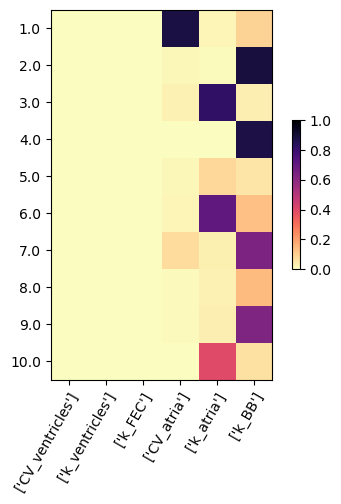

In [59]:
inputs = x_labels.values.tolist()
outputs = np.linspace(1,10,10)
fig, ax = plt.subplots()
im = ax.imshow(SiA_first.T[0:10],cmap='magma_r',vmin=0,vmax=1)

ax.set_yticks(np.arange(len(outputs)),labels=outputs)
ax.set_xticks(np.arange(len(inputs)), labels=inputs)
plt.setp(ax.get_xticklabels(), rotation=60, ha="right",
         rotation_mode="anchor");

plt.colorbar(im,fraction=0.015, pad=0.04)

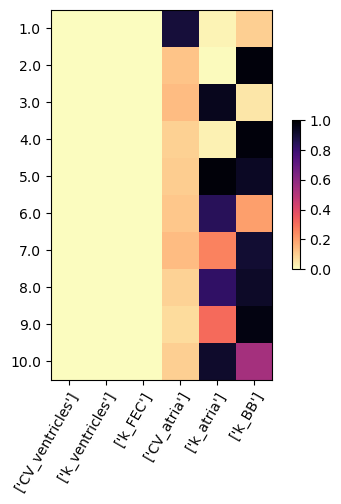

In [60]:
inputs = x_labels.values.tolist()
outputs = np.linspace(1,10,10)
fig, ax = plt.subplots()
im = ax.imshow(SiA_total.T[0:10],cmap='magma_r',vmin=0,vmax=1)

ax.set_yticks(np.arange(len(outputs)),labels=outputs)
ax.set_xticks(np.arange(len(inputs)), labels=inputs)
plt.setp(ax.get_xticklabels(), rotation=60, ha="right",
         rotation_mode="anchor");

plt.colorbar(im,fraction=0.015, pad=0.04)

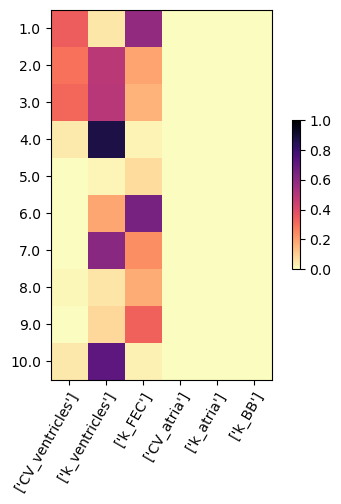

In [61]:
inputs = x_labels.values.tolist()
outputs = np.linspace(1,10,10)
fig, ax = plt.subplots()
im = ax.imshow(SiV_first.T[0:10],cmap='magma_r',vmin=0,vmax=1)

ax.set_yticks(np.arange(len(outputs)),labels=outputs)
ax.set_xticks(np.arange(len(inputs)), labels=inputs)
plt.setp(ax.get_xticklabels(), rotation=60, ha="right",
         rotation_mode="anchor");

plt.colorbar(im,fraction=0.015, pad=0.04)

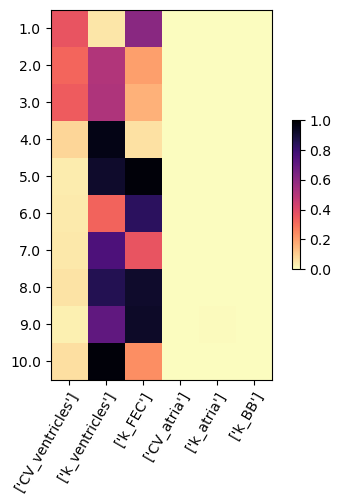

In [62]:
inputs = x_labels.values.tolist()
outputs = np.linspace(1,10,10)
fig, ax = plt.subplots()
im = ax.imshow(SiV_total.T,cmap='magma_r',vmin=0,vmax=1)

ax.set_yticks(np.arange(len(outputs)),labels=outputs)
ax.set_xticks(np.arange(len(inputs)), labels=inputs)
plt.setp(ax.get_xticklabels(), rotation=60, ha="right",
         rotation_mode="anchor");

plt.colorbar(im,fraction=0.015, pad=0.04)

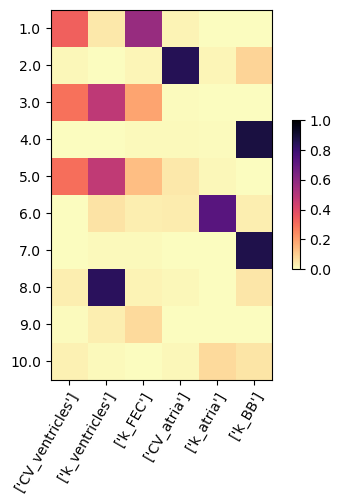

In [133]:
inputs = x_labels.values.tolist()
outputs = np.linspace(1,10,10)
fig, ax = plt.subplots()
im = ax.imshow(SiC_first.T,cmap='magma_r',vmin=0,vmax=1)

ax.set_yticks(np.arange(len(outputs)),labels=outputs)
ax.set_xticks(np.arange(len(inputs)), labels=inputs)
plt.setp(ax.get_xticklabels(), rotation=60, ha="right",
         rotation_mode="anchor");

plt.colorbar(im,fraction=0.015, pad=0.04)

In [63]:
np.max(PCA_test_c,axis=1)

26     232.374
56     146.857
50     237.832
103    174.198
25     145.946
65     257.471
1      251.071
23     263.611
170    148.134
27     253.479
40     238.058
122    269.679
130    123.167
126    251.182
89     243.399
121    293.923
52     200.845
80     200.132
127    307.759
4      140.815
139    162.071
134    141.697
131    185.618
153    236.319
156    181.940
17     284.215
172    194.967
135    189.753
159    275.184
3      110.694
152    120.467
90     262.326
146    256.638
132    328.284
117    200.136
69     172.419
dtype: float64

In [95]:
X=inputOrig
y=allSimulationsOutput_combined.T

X_train2, X_test2, PCA_train_c, PCA_test_c = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=seed
)

In [96]:
np.max(PCA_test_c,axis=1)

26     232.374
56     146.857
50     237.832
103    174.198
25     145.946
65     257.471
1      251.071
23     263.611
170    148.134
27     253.479
40     238.058
122    269.679
130    123.167
126    251.182
89     243.399
121    293.923
52     200.845
80     200.132
127    307.759
4      140.815
139    162.071
134    141.697
131    185.618
153    236.319
156    181.940
17     284.215
172    194.967
135    189.753
159    275.184
3      110.694
152    120.467
90     262.326
146    256.638
132    328.284
117    200.136
69     172.419
dtype: float64

In [97]:
X_test2

,"(CV_ventricles,)","(k_ventricles,)","(k_FEC,)","(CV_atria,)","(k_atria,)","(k_BB,)"
26,0.556019,0.336764,2.42194,0.552269,0.215546,2.00919
56,0.476766,0.383700,5.84953,0.910181,0.211079,2.80336
50,0.471244,0.320540,1.49320,1.019540,0.288555,4.60673
103,0.731321,0.260462,4.32422,0.633458,0.415970,2.31854
25,0.712580,0.481613,7.29542,0.685247,0.424855,5.57871
65,0.737321,0.359975,1.84114,0.403365,0.462289,3.01100
1,0.411078,0.484808,2.97470,0.436497,0.392057,2.72577
23,0.578632,0.350655,6.38964,0.380593,0.425437,5.41200
170,0.529865,0.223555,7.78364,0.858425,0.320887,2.64242
27,0.715493,0.405499,2.19868,0.457758,0.263826,3.41692


In [98]:
end=10
GPE_output_c = pd.DataFrame(principalComponents_EP_c[:,0:end])

In [99]:
testOutPCA_c = pca_EP_c.transform(PCA_test_c)

In [100]:
GPE_C = GPE.ensemble(X_train,GPE_output_c,mean_func='linear')

0
1
2
3
4
5
6
7
8
9


In [103]:
GPE_C.MSE(X_test2,pd.DataFrame(testOutPCA_c[:,0:end])).detach().numpy()

array([0.99914895, 0.99912272, 0.99846101, 0.9982181 , 0.99824011,
       0.9932407 , 0.9687988 , 0.96340849, 0.974066  , 0.94864414])

In [104]:
compPred_C = GPE_C.predict(X_test2)

In [129]:
((np.matmul(compPred_C.detach().numpy()[:,0:end],pca_EP_c.components_[0:j])+pca_EP_c.mean_-PCA_test_c)**2).mean(axis=1)

26     0.340890
56     0.124634
50     1.638376
103    0.122581
25     1.200548
65     0.231405
1      0.958919
23     0.640137
170    0.190082
27     0.193962
40     0.179969
122    1.502205
130    0.491350
126    1.532292
89     0.558847
121    0.329578
52     0.653121
80     0.097603
127    2.340758
4      0.116765
139    0.592353
134    0.251223
131    1.442439
153    0.339600
156    0.142105
17     0.954337
172    0.113632
135    2.371562
159    0.107564
3      0.825758
152    0.855342
90     0.820712
146    2.481270
132    2.221153
117    0.539123
69     0.380934
dtype: float64

In [106]:
PCA_test_c.max(axis=1)

26     232.374
56     146.857
50     237.832
103    174.198
25     145.946
65     257.471
1      251.071
23     263.611
170    148.134
27     253.479
40     238.058
122    269.679
130    123.167
126    251.182
89     243.399
121    293.923
52     200.845
80     200.132
127    307.759
4      140.815
139    162.071
134    141.697
131    185.618
153    236.319
156    181.940
17     284.215
172    194.967
135    189.753
159    275.184
3      110.694
152    120.467
90     262.326
146    256.638
132    328.284
117    200.136
69     172.419
dtype: float64

In [109]:
sim_recon = np.matmul(compPred_C.detach().numpy()[:,0:end],pca_EP_c.components_[0:j])+pca_EP_c.mean_

In [110]:
sim_recon

array([[ 51.42485105,  48.746662  ,  51.05572393, ..., 139.69707209,
          8.53482749, 114.60600862],
       [ 31.45492942,  29.7699043 ,  31.1489619 , ..., 108.99658183,
          4.17036711,  84.47981268],
       [ 23.74034408,  22.30394748,  23.37363961, ..., 211.79450119,
         16.51405964, 186.11203538],
       ...,
       [ 64.13648895,  59.75110828,  63.62645558, ..., 125.82290133,
          6.33377704, 104.90136314],
       [ 37.7563997 ,  35.15375749,  37.40387165, ..., 117.9858241 ,
          6.19752757,  95.79799748],
       [ 34.00300176,  31.97882526,  33.71889204, ...,  73.17269892,
          2.39091056,  57.28614223]])

In [111]:
allSimulationsOutput_ventricles.shape

(336606, 180)

In [112]:
allSimulationsOutput_atria.shape

(97985, 180)

In [82]:
336606+97985

434591

In [113]:
sim_atria = sim_recon[:,0:97985]

In [114]:
sim_ventricle = sim_recon[:,97985:434591]

In [116]:
X_test2.index

Int64Index([ 26,  56,  50, 103,  25,  65,   1,  23, 170,  27,  40, 122, 130,
            126,  89, 121,  52,  80, 127,   4, 139, 134, 131, 153, 156,  17,
            172, 135, 159,   3, 152,  90, 146, 132, 117,  69],
           dtype='int64')

In [117]:
import json
import numpy as np

def json_to_init(stimuli, tag_file, json_param_file, init_file_name):

    # Read tags
    f_input = open(tag_file,"r")
    tags = json.load(f_input)
    f_input.close()

    # Read CVs
    f_input = open(json_param_file,"r")
    params = json.load(f_input)
    f_input.close()

    tags_ventricles_names = ["LV", "RV"]
    CV_ventricle_name = "CV_ventricles"
    k_ventricles_name = "k_ventricles"

    tags_FEC_names = ["FEC_LV", "FEC_RV", "FEC_SV"]
    k_FEC_name = "k_FEC"

    tags_atria_names = ["LA", "RA"]
    CV_atria_name = "CV_atria"
    k_atria_name = "k_atria"

    tags_bachmann_names = ["BB"]
    k_BB_name = "k_BB"

    vtx = []
    nVtx = 0

    for vtxFile in stimuli:
        temp = np.loadtxt(vtxFile, dtype=int, skiprows=2, ndmin=1)
        vtx.append(temp)
        nVtx += temp.shape[0]

    # write .init file
    f = open(init_file_name,'w')

    # header
    f.write('vf:0 vs:0 vn:0 vPS:0\n') # Default properties for tags not specified
    f.write('retro_delay:0 antero_delay:0\n') # If there's no 1D purkinje system, it's ignored.
    # number of stimuli and regions
    f.write('%d %d\n' % (int(nVtx), int(len(tags_ventricles_names)) + len(tags_FEC_names) + len(tags_atria_names) + len(tags_bachmann_names)))
    # stimulus
    for i in range(len(vtx)):
        if len(vtx[i]) == 1:
            f.write('%d %f\n' % (vtx[i],0))
        else:
            for n in vtx[i]:
                f.write('%d %f\n' % (int(n),0))
                
    return_tags_str = ''
    # ek regions
    for i,tag_name in enumerate(tags_ventricles_names):
        f.write('%d %f %f %f\n' % (int(tags[tag_name]), 
                                   float(params["EP"][CV_ventricle_name]), 
                                   float(params["EP"][CV_ventricle_name])*float(params["EP"][k_ventricles_name]), 
                                   float(params["EP"][CV_ventricle_name])*float(params["EP"][k_ventricles_name])))
        return_tags_str += ',' + str(int(tags[tag_name]))

    for i,tag_name in enumerate(tags_FEC_names):
        f.write('%d %f %f %f\n' % (int(tags[tag_name]), 
                                   float(params["EP"][CV_ventricle_name])*float(params["EP"][k_FEC_name]), 
                                   float(params["EP"][CV_ventricle_name])*float(params["EP"][k_FEC_name]), 
                                   float(params["EP"][CV_ventricle_name])*float(params["EP"][k_FEC_name])))
        return_tags_str += ',' + str(int(tags[tag_name]))

    for i,tag_name in enumerate(tags_atria_names):
        f.write('%d %f %f %f\n' % (int(tags[tag_name]), 
                                   float(params["EP"][CV_atria_name]), 
                                   float(params["EP"][CV_atria_name])*float(params["EP"][k_atria_name]), 
                                   float(params["EP"][CV_atria_name])*float(params["EP"][k_atria_name])))
        return_tags_str += ',' + str(int(tags[tag_name]))

    for i,tag_name in enumerate(tags_bachmann_names):
        f.write('%d %f %f %f\n' % (int(tags[tag_name]), 
                                   float(params["EP"][CV_atria_name])*float(params["EP"][k_BB_name]), 
                                   float(params["EP"][CV_atria_name])*float(params["EP"][k_BB_name]), 
                                   float(params["EP"][CV_atria_name])*float(params["EP"][k_BB_name])))
        return_tags_str += ',' + str(int(tags[tag_name]))

    f.close()
    
    return return_tags_str[1:]

In [127]:


basefolder = "/Users/pmzcwl/Documents/GitHub/Calibration/shared_simulations/EP_healthy/output/simulations"
elem_file = "/Users/pmzcwl/Documents/GitHub/Calibration/shared_simulations/mesh/myocardium_AV_FEC_BB_lvrv.elem"
tag_file = '/Users/pmzcwl/Documents/GitHub/Calibration/shared_simulations/mesh/tags_lvrv.json'

f_input = open(tag_file,"r")
tags = json.load(f_input)
f_input.close()


tags_modified = tags.copy()
tags_modified["ventricles"] = [tags_modified["LV"], tags_modified["RV"]]
tags_modified["fast_endo"] = [tags_modified["FEC_RV"], tags_modified["FEC_SV"]]
tags_modified["atria"] = [tags_modified["LA"], tags_modified["RA"]]
tags_modified["bachmann_bundle"] = [tags_modified["BB"]]

output_path = "/Users/pmzcwl/Documents/GitHub/Calibration/shared_simulations/EP_healthy/output"

os.makedirs(output_path,exist_ok=True)

print('Reading mesh elem file...')
elem = np.loadtxt(elem_file,dtype=int,usecols=[1,2,3,4,5],skiprows=1)
print('Done.')

V_EIDX = np.where(np.isin(elem[:,-1],tags_modified["ventricles"]+tags_modified["fast_endo"])==1)[0]
A_EIDX = np.where(np.isin(elem[:,-1],tags_modified["atria"]+tags_modified["bachmann_bundle"])==1)[0]

V_VTX = np.unique(elem[V_EIDX,0:4].flatten())
A_VTX = np.unique(elem[A_EIDX,0:4].flatten())

for i, val in enumerate(X_test2.index):

    print('Computing output for '+str(val)+'.dat...')
    AT=np.loadtxt(os.path.join(basefolder,str(val)+".dat"),dtype=float)
    AT[A_VTX]=sim_atria[i,:]

    AT[V_VTX]=sim_ventricle[i,:]

    mesh=pyvista.read('/Users/pmzcwl/Documents/GitHub/Calibration/shared_simulations/mesh/myocardium_AV_FEC_BB_lvrv.vtk')
    scalars=AT
    mesh.point_data['points']=scalars
    mesh.save(str(val)+'_sim_recon.vtu')
    
    scalars=AT-np.loadtxt(os.path.join(basefolder,str(val)+".dat"),dtype=float)
    mesh.point_data['points']=scalars
    mesh.save(str(val)+'_sim_diff.vtu')
    
    scalars=np.loadtxt(os.path.join(basefolder,str(val)+".dat"),dtype=float)
    mesh.point_data['points']=scalars
    mesh.save(str(val)+'_sim.vtu')

Reading mesh elem file...
Done.
Computing output for 26.dat...
Computing output for 56.dat...
Computing output for 50.dat...
Computing output for 103.dat...
Computing output for 25.dat...
Computing output for 65.dat...
Computing output for 1.dat...
Computing output for 23.dat...
Computing output for 170.dat...
Computing output for 27.dat...
Computing output for 40.dat...
Computing output for 122.dat...
Computing output for 130.dat...
Computing output for 126.dat...
Computing output for 89.dat...
Computing output for 121.dat...
Computing output for 52.dat...
Computing output for 80.dat...
Computing output for 127.dat...
Computing output for 4.dat...
Computing output for 139.dat...
Computing output for 134.dat...
Computing output for 131.dat...
Computing output for 153.dat...
Computing output for 156.dat...
Computing output for 17.dat...
Computing output for 172.dat...
Computing output for 135.dat...
Computing output for 159.dat...
Computing output for 3.dat...
Computing output for 152.d

In [121]:
np.abs(AT-np.loadtxt(os.path.join(basefolder,str(val)+".dat"),dtype=float))


array([0.41820088, 0.43423453, 0.39597025, ..., 1.17550627, 0.67100177,
       0.29078779])

In [87]:
print('Reading mesh elem file...')
elem = np.loadtxt(elem_file,dtype=int,usecols=[1,2,3,4,5],skiprows=1)
print('Done.')

V_EIDX = np.where(np.isin(elem[:,-1],tags_modified["ventricles"]+tags_modified["fast_endo"])==1)[0]
A_EIDX = np.where(np.isin(elem[:,-1],tags_modified["atria"]+tags_modified["bachmann_bundle"])==1)[0]

V_VTX = np.unique(elem[V_EIDX,0:4].flatten())
A_VTX = np.unique(elem[A_EIDX,0:4].flatten())


print('Computing output for '+str(26)+'.dat...')
AT=np.loadtxt(os.path.join(basefolder,str(26)+".dat"),dtype=float)
AT[A_VTX]=sim26_atria

AT[V_VTX]=sim26_ventricle

Reading mesh elem file...
Done.
Computing output for 26.dat...


In [88]:
AT.max()

233.45695253027972

In [89]:
np.savetxt("sim26_recon.dat",AT,fmt="%g")

In [90]:
import pyvista

In [91]:
mesh=pyvista.read('/Users/pmzcwl/Documents/GitHub/Calibration/shared_simulations/mesh/myocardium_AV_FEC_BB_lvrv.vtk')

In [92]:
scalars=AT

In [93]:
mesh.point_data['points']=scalars

In [94]:
mesh.save('26_sim_recon.vtu')